In [566]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from functools import wraps, reduce
import time

In [160]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [2]:
os.getcwd()

'/Users/iliasoroka/Documents/Computattional science/Stochastic simulations/Assigments/simulated_annealing'

In [3]:
#path= "/Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/"
#os.chdir(path)

In [607]:
def read_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cities = []
    for line in lines:
        parts = line.split()
        if len(parts) == 3 and parts[0].isdigit():
            cities.append((float(parts[1]), float(parts[2])))

    return cities

In [25]:
cities

[(37.0, 52.0),
 (49.0, 49.0),
 (52.0, 64.0),
 (20.0, 26.0),
 (40.0, 30.0),
 (21.0, 47.0),
 (17.0, 63.0),
 (31.0, 62.0),
 (52.0, 33.0),
 (51.0, 21.0),
 (42.0, 41.0),
 (31.0, 32.0),
 (5.0, 25.0),
 (12.0, 42.0),
 (36.0, 16.0),
 (52.0, 41.0),
 (27.0, 23.0),
 (17.0, 33.0),
 (13.0, 13.0),
 (57.0, 58.0),
 (62.0, 42.0),
 (42.0, 57.0),
 (16.0, 57.0),
 (8.0, 52.0),
 (7.0, 38.0),
 (27.0, 68.0),
 (30.0, 48.0),
 (43.0, 67.0),
 (58.0, 48.0),
 (58.0, 27.0),
 (37.0, 69.0),
 (38.0, 46.0),
 (46.0, 10.0),
 (61.0, 33.0),
 (62.0, 63.0),
 (63.0, 69.0),
 (32.0, 22.0),
 (45.0, 35.0),
 (59.0, 15.0),
 (5.0, 6.0),
 (10.0, 17.0),
 (21.0, 10.0),
 (5.0, 64.0),
 (30.0, 15.0),
 (39.0, 10.0),
 (32.0, 39.0),
 (25.0, 32.0),
 (25.0, 55.0),
 (48.0, 28.0),
 (56.0, 37.0),
 (30.0, 40.0)]

In [570]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'eil51.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

In [699]:
def normalise_dist(cities):
   """Takes cities array and returns normolised to 0 - 1 coordinates"""
   devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
   x_coord, y_coord = devider(cities)
   minmax_x = (min(x_coord), max(x_coord))
   minmax_y = (min(y_coord), max(y_coord))
   normalizer = lambda minmax_x, x_coord: [(x - minmax_x[0]) / (minmax_x[1] - minmax_x[0]) for x in x_coord]
   normalized_x = normalizer(minmax_x, x_coord)
   normalized_y = normalizer(minmax_y, y_coord)
   reconstructor = lambda a, b: (a, b)
   normalised = list(map(reconstructor, normalized_x, normalized_y))
   return normalised

In [769]:
def denormalise_dist(cities, norm_coord):
    """Takes cities, x normalised and y normalised coordinatesand returns denormolised coordinates"""
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    x_norm , y_norm = devider(norm_coord)
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    denormalize = lambda minmax, norm_coords: [x * (minmax[1] - minmax[0]) + minmax[0] for x in norm_coords]
    denormalized_x = denormalize(minmax_x, x_norm)
    denormalized_y = denormalize(minmax_y, y_norm)
    reconstructor = lambda a, b: (a, b)
    denormalised = list(map(reconstructor, denormalized_x, denormalized_y))
    return denormalised

In [773]:
cities = read_tsp_file(file_path)
normalised = normalise_dist(cities)
print(normalised)
renormalised = denormalise_dist(cities,normalised)
renormalised

[(0.5517241379310345, 0.7301587301587301), (0.7586206896551724, 0.6825396825396826), (0.8103448275862069, 0.9206349206349206), (0.25862068965517243, 0.31746031746031744), (0.603448275862069, 0.38095238095238093), (0.27586206896551724, 0.6507936507936508), (0.20689655172413793, 0.9047619047619048), (0.4482758620689655, 0.8888888888888888), (0.8103448275862069, 0.42857142857142855), (0.7931034482758621, 0.23809523809523808), (0.6379310344827587, 0.5555555555555556), (0.4482758620689655, 0.4126984126984127), (0.0, 0.30158730158730157), (0.1206896551724138, 0.5714285714285714), (0.5344827586206896, 0.15873015873015872), (0.8103448275862069, 0.5555555555555556), (0.3793103448275862, 0.2698412698412698), (0.20689655172413793, 0.42857142857142855), (0.13793103448275862, 0.1111111111111111), (0.896551724137931, 0.8253968253968254), (0.9827586206896551, 0.5714285714285714), (0.6379310344827587, 0.8095238095238095), (0.1896551724137931, 0.8095238095238095), (0.05172413793103448, 0.73015873015873

[(37.0, 52.0),
 (49.0, 49.0),
 (52.0, 64.0),
 (20.0, 26.0),
 (40.0, 30.0),
 (21.0, 47.0),
 (17.0, 63.0),
 (31.0, 62.0),
 (52.0, 33.0),
 (51.0, 21.0),
 (42.0, 41.0),
 (31.0, 32.0),
 (5.0, 25.0),
 (12.0, 42.0),
 (36.0, 16.0),
 (52.0, 41.0),
 (27.0, 23.0),
 (17.0, 33.0),
 (13.0, 13.0),
 (57.0, 58.0),
 (62.0, 42.0),
 (42.0, 57.0),
 (16.0, 57.0),
 (8.0, 52.0),
 (7.0, 38.0),
 (27.0, 68.0),
 (30.0, 48.0),
 (43.0, 67.0),
 (58.0, 48.0),
 (58.0, 27.0),
 (37.0, 69.0),
 (38.0, 46.0),
 (46.0, 10.0),
 (61.0, 33.0),
 (62.0, 63.0),
 (63.0, 69.0),
 (32.0, 22.0),
 (45.0, 35.0),
 (59.0, 15.0),
 (5.0, 6.0),
 (10.0, 17.0),
 (21.0, 10.0),
 (5.0, 64.0),
 (30.0, 15.0),
 (39.0, 10.0),
 (32.0, 39.0),
 (25.0, 32.0),
 (25.0, 55.0),
 (48.0, 28.0),
 (56.0, 37.0),
 (30.0, 40.0)]

In [731]:
def calculate_total_distance(tour, cities):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city2 = cities[tour[i + 1]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    # Return to the starting city
    total_distance += math.sqrt((cities[tour[-1]][0] - cities[tour[0]][0])**2 +
                                (cities[tour[-1]][1] - cities[tour[0]][1])**2)

    return total_distance

In [764]:
def calculate_total_distance_with_denorm(tour, cities, denorm):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city1 = denorm(cities, city1)
        city2 = cities[tour[i + 1]]
        city2 = denorm(cities, city2)
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    # Return to the starting city
    total_distance += math.sqrt((cities[tour[-1]][0] - cities[tour[0]][0])**2 +
                                (cities[tour[-1]][1] - cities[tour[0]][1])**2)

    return total_distance

In [1012]:
@timeit
def simulated_annealing(cities, initial_temperature=1, cooling_rate=0.9995, num_iterations=50000):
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    np.random.shuffle(current_tour)
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    for iteration in range(num_iterations):
        # generate a random neighboring tour by swapping two cities
        new_tour = current_tour[:]
        i, j = sorted(random.sample(range(num_cities), 2))
        new_tour[i:j+1] = reversed(new_tour[i:j+1])
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        #print(math.exp(-delta_distance / temperature))
        if delta_distance <= 0:
            fitnes.append(new_distance)
            fitnes_t.append(iteration) 
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
        else:
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)
            prob_array.append(math.exp(argument))
            t.append(iteration)
            if iteration % 100 == 0:
                print(f"The iteration is {iteration}, the temperature is {temperature}")
                print(f"The current random variable is {random_u}, the probability threhoold is less then {math.exp(argument)}")
            if math.exp(argument) > random_u:
                current_tour = new_tour
                current_distance = new_distance
        # cool down the temperature
        """ if iteration % 3 != 0:"""
        if iteration % 10 == 0:
            temperature *= cooling_rate**2
            temp_array.append(temperature)


    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t

In [481]:
for iteration in range(10):
    if iteration % 2 != 0:
        print(iteration)

1
3
5
7
9


In [635]:

def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()


In [7]:
os.getcwd()

'/Users/iliasoroka/Documents/Computattional science/Stochastic simulations/Assigments/simulated_annealing'

In [8]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'eil51.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

#file_path = "/Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/eil51.tsp"

In [9]:
ls -l /Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/eil51.tsp.txt

ls: /Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/eil51.tsp.txt: No such file or directory


In [11]:
ls -l /Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/

total 72
-rw-r--r--@ 1 aleksandar  staff   1092 Jun  1  1995 a280.opt.tour.txt
-rw-r--r--@ 1 aleksandar  staff   3483 Jun  1  1995 a280.tsp.txt
-rw-r--r--@ 1 aleksandar  staff    257 Jun  1  1995 eil51.opt.tour.txt
-rw-r--r--@ 1 aleksandar  staff    579 Jun  1  1995 eil51.tsp.txt
-rw-r--r--@ 1 aleksandar  staff   1777 Jun  1  1995 pcb442.opt.tour.txt
-rw-r--r--@ 1 aleksandar  staff  12414 Jun  1  1995 pcb442.tsp.txt


The iteration is 100, the temperature is 0.9900473578023301
The current random variable is 0.4983542607124313, the probability threhoold is less then 0.8021616204663639
The iteration is 300, the temperature is 0.9704382528072989
The current random variable is 0.7919186495394148, the probability threhoold is less then 0.7135745845484334
The iteration is 400, the temperature is 0.9607798281021759
The current random variable is 0.45753967621328406, the probability threhoold is less then 0.24092424166530022
The iteration is 500, the temperature is 0.9512175302423361
The current random variable is 0.37972729994493215, the probability threhoold is less then 0.536566727688398
The iteration is 800, the temperature is 0.9230978780880464
The current random variable is 0.6628739616140847, the probability threhoold is less then 0.21195245116958386
The iteration is 1000, the temperature is 0.9048147898403291
The current random variable is 0.7176054922153979, the probability threhoold is less then 0

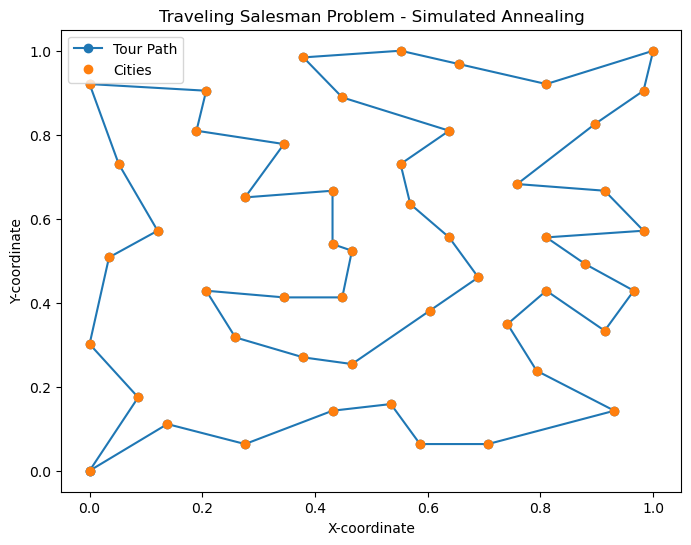

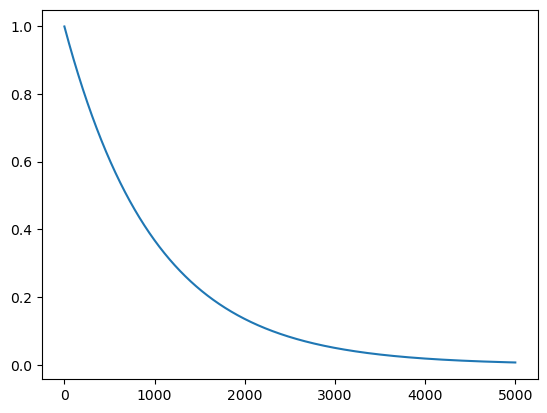

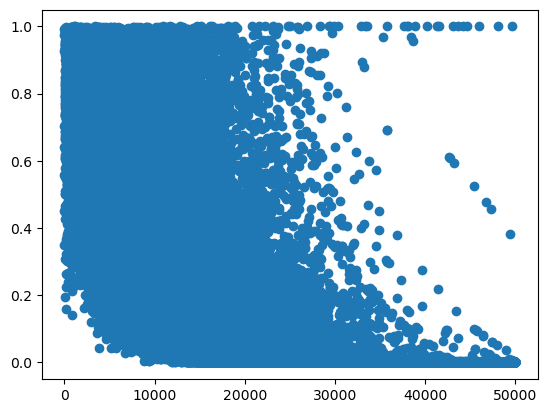

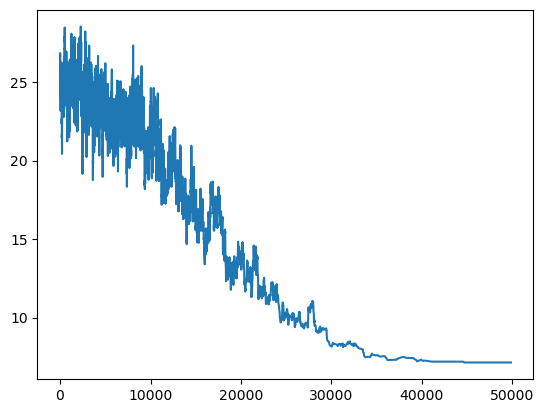

In [1014]:
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    cities_norm = normalise_dist(cities)
    best_tour, best_distance, temp_arr, prob, t, fit, ft = simulated_annealing(cities_norm)
    x = [cities[city][0] for city in best_tour]
    y = [cities[city][1] for city in best_tour]
    x.append(x[0])
    y.append(y[0])
    best_distance = calculate_total_distance(best_tour, cities)
    coord_denorm = list(zip(x, y))
    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)
    plot_tour(best_tour, cities_norm)
    x = np.linspace(0, len(temp_arr), len(temp_arr))
    plt.plot(x, temp_arr)
    plt.show()
    plt.scatter(t, prob)
    plt.show()
    plt.plot(ft, fit)
    plt.show()

In [330]:
print(np.sum(best_tour))

1275


In [328]:
from collections import Counter

def has_repeated_cities(tour):
    city_counts = Counter(tour)
    return any(count > 1 for count in city_counts.values())

if has_repeated_cities(best_tour):
    print("There are repeated cities in the tour.")
else:
    print("No repeated cities in the tour.")

No repeated cities in the tour.


In [13]:
print(tsp_file_path)

TSP-Configurations/eil51.tsp.txt


In [282]:
def two_opt(tour):
    # apply 2-opt move
    i, j = random.sample(range(len(tour)), 2)
    i, j = sorted([i, j])
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

In [283]:
def move_city(tour):
    # apply move of a single city
    i, j = random.sample(range(len(tour)), 2)
    city = tour.pop(i)
    tour.insert(j, city)
    return tour

In [284]:
def simulated_annealing_tomc(cities, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    random.shuffle(current_tour)
    current_distance = calculate_total_distance(current_tour, cities)

    best_tour = current_tour[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(num_iterations):
        # Choose a random elementary edit
        if random.uniform(0, 1) < 0.5:
            new_tour = two_opt(current_tour)
        else:
            new_tour = move_city(current_tour)

        # Calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)

        # Decide whether to accept the new tour
        if new_distance < current_distance or random.uniform(0, 1) < math.exp((current_distance - new_distance) / temperature):
            current_tour = new_tour
            current_distance = new_distance

            # Update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        # Cool down the temperature
        temperature *= cooling_rate

    return best_tour, best_distance

In [574]:

def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()


Best Tour: [38, 24, 27, 22, 12, 18, 39, 14, 33, 0, 9, 41, 13, 23, 3, 44, 50, 20, 28, 26, 16, 15, 21, 19, 34, 46, 10, 37, 40, 43, 47, 31, 25, 42, 48, 1, 6, 2, 30, 45, 5, 8, 29, 49, 32, 36, 4, 35, 7, 11, 17]
Best Distance: 1315.3790499546542


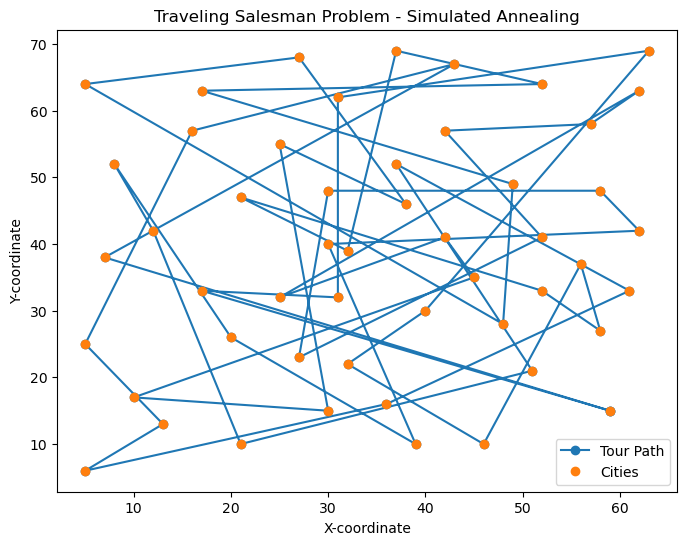

In [576]:
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    best_tour, best_distance = simulated_annealing_tomc(cities)
    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)
    plot_tour(best_tour, cities)

In [577]:
def run_multiple_simulations(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

In [578]:
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)

    best_tour, best_distance = run_multiple_simulations(cities, num_simulations=100)

    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)

    plot_tour(best_tour, cities)

The iteration is 0, the temperature is 5000
The current random variable is 0.6786998676168622, the probability threhoold is less then 0.9944016412624535
The iteration is 100, the temperature is 4523.9607355685475
The current random variable is 0.09850016122689453, the probability threhoold is less then 0.9909111863701195
The iteration is 200, the temperature is 4093.2441473931776
The current random variable is 0.07081550868477948, the probability threhoold is less then 0.9945534702852293
The iteration is 400, the temperature is 3350.9295300337003
The current random variable is 0.8876997834203041, the probability threhoold is less then 0.990536449601013
The iteration is 500, the temperature is 3031.894724305924
The current random variable is 0.8486224067165592, the probability threhoold is less then 0.9895446831442604
The iteration is 800, the temperature is 2245.745743050375
The current random variable is 0.42655396170594073, the probability threhoold is less then 0.9768378954409765
Th

KeyboardInterrupt: 